In [479]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from category_encoders import JamesSteinEncoder #not sure if using
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
import pandas as pd
from sklearn import datasets

In [558]:
styles = pd.read_csv("data/styles.csv",on_bad_lines='skip')
styles.head()
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [726]:
# Don't include Free Gifts, that is a confusing category and will confuse the models
styles = styles[styles['articleType'] != 'Free Gifts']
styles[styles['articleType']=='Free Gifts'].head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path


In [562]:
# Create a new column with full image file paths
styles['image_path'] = styles['id'].apply(lambda x: os.path.join("data\\images", f"{x}.jpg"))
styles = styles[styles['image_path'].apply(os.path.exists)]
print (len(styles))
# Check the result
print(styles[['id', 'image_path']].head())

20462
      id             image_path
0  15970  data\images\15970.jpg
3  21379  data\images\21379.jpg
5   1855   data\images\1855.jpg
6  30805  data\images\30805.jpg
7  26960  data\images\26960.jpg


In [487]:
# DATA CLEANING

from category_encoders import JamesSteinEncoder

styles['productDisplayName'] = styles['productDisplayName'].fillna('Unknown Product')
usage_mode = styles['usage'].mode()[0]
styles['usage'] = styles['usage'].fillna(usage_mode)
color_mode = styles['baseColour'].mode()[0]

# Fill missing values
styles['baseColour'] = styles['baseColour'].fillna(color_mode)

styles.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [23]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,data\images\15970.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,data\images\21379.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,data\images\1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,data\images\30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,data\images\26960.jpg


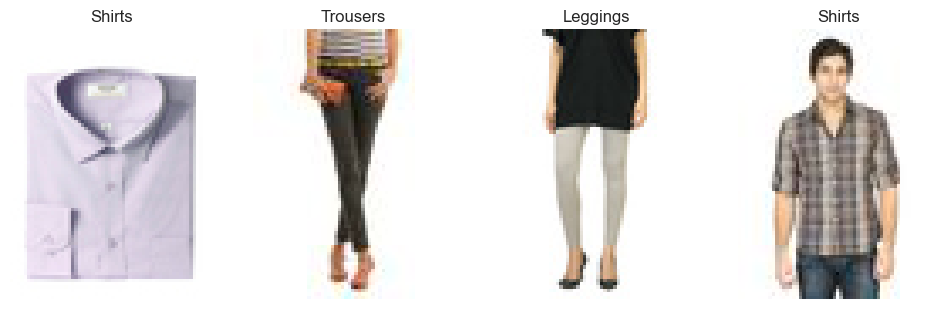

In [489]:
from PIL import Image

# Display the first image
#img = Image.open(styles.iloc[0]['image_path'])
#img.show()


# Choose 4 random rows
sample = styles.sample(4)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, (_, row) in zip(axes, sample.iterrows()):
    image = Image.open(row['image_path']).convert('RGB')
    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title(row['articleType'])  # or use subCategory, gender, etc.



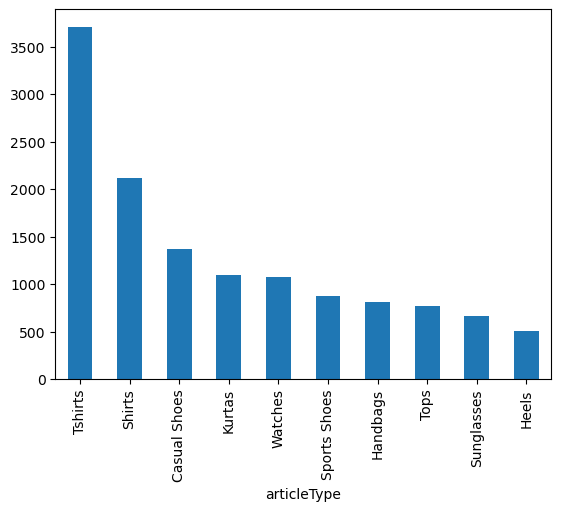

In [186]:
styles["articleType"].value_counts().nlargest(10).plot(kind='bar')

plt.show()

In [491]:
IMAGE_SIZE = (64, 64)

def preprocess_image(path):
    img = Image.open(path).convert('L').resize(IMAGE_SIZE)
    return np.array(img).flatten()  # Shape: (4096,)

# Flatten all images
X = np.array([preprocess_image(p) for p in styles['image_path']])


In [190]:
# Create a classifier: a knn classifier to test
clf = KNeighborsClassifier()

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
   X, styles['articleType'], test_size=0.2, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)
print (y_test)
print (predicted)
test_accuracy = clf.score(X_test, y_test)
print("Accuracy:", test_accuracy)

35565           Heels
35566    Casual Shoes
35568            Tops
35569        Handbags
35571         Wallets
             ...     
44414         Tshirts
44415         Tshirts
44417         Tshirts
44419    Casual Shoes
44421         Tshirts
Name: articleType, Length: 4093, dtype: object
['Casual Shoes' 'Casual Shoes' 'Tops' ... 'Tops' 'Casual Shoes' 'Tshirts']
Accuracy: 0.7500610798924994


In [192]:
# Print out the actual and predicted values
for i, (true, pred) in enumerate(zip(y_test.values, predicted)):
    if i == 10:
        break
    print(f"Actual: {true} — Predicted: {pred}")

Actual: Heels — Predicted: Casual Shoes
Actual: Casual Shoes — Predicted: Casual Shoes
Actual: Tops — Predicted: Tops
Actual: Handbags — Predicted: Handbags
Actual: Wallets — Predicted: Wallets
Actual: Tshirts — Predicted: Tshirts
Actual: Tshirts — Predicted: Shirts
Actual: Tshirts — Predicted: Tshirts
Actual: Kurtas — Predicted: Kurtas
Actual: Sweatshirts — Predicted: Shirts


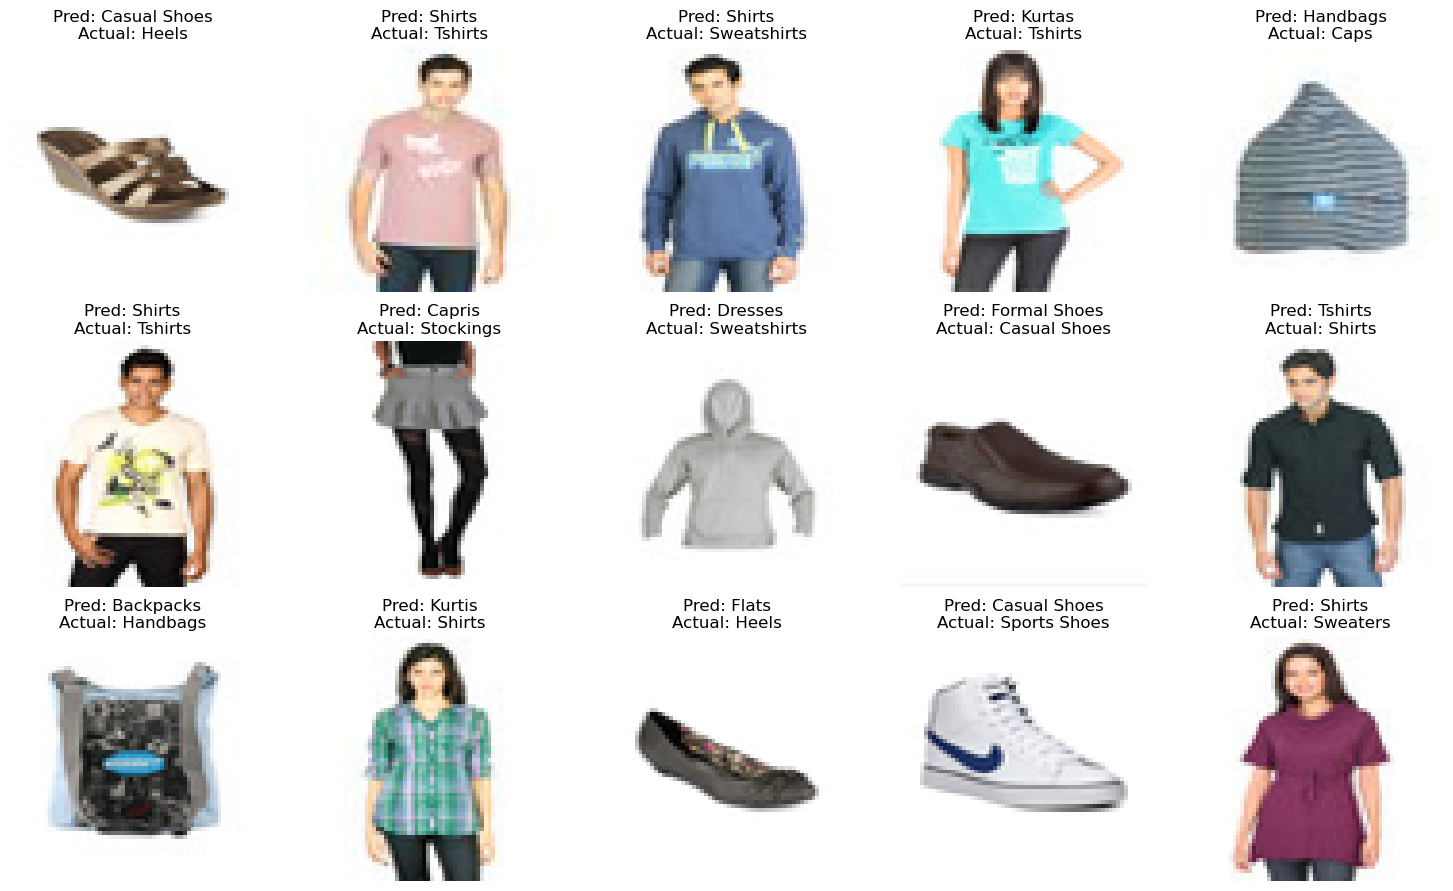

In [194]:
import matplotlib.pyplot as plt
import math

# Get the test set image paths
test_paths = styles.loc[y_test.index, 'image_path'].values  # ✅

# Loop through and show incorrect predictions
wrong = [(i, p, a) for i, (p, a) in enumerate(zip(predicted, y_test.values)) if p != a]
#Number of images you want to show
show_num = 15  # for example

# Set number of columns (images per row)
cols = 5
rows = math.ceil(show_num / cols)

plt.figure(figsize=(3 * cols, 3 * rows))  # adjust size as needed

# View the images of the incorrectly categorized data
for i, (idx, pred, actual) in enumerate(wrong[:show_num]):
    img = Image.open(test_paths[idx]).resize((64, 64))
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Pred: {pred}\nActual: {actual}')

plt.tight_layout()
plt.show()

# Above shows some of the misclassified items. ^ 

It makes sense that different categories of shoes might get confused. <br>
It also makes sense that there would be confusion among the different types of tops, so the data is making sense.



## Try multiple models to see what works

In [493]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# define the models
models = {
    'kNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(
            max_depth=10,          # Prevents overfitting; try values like 5–20
            min_samples_split=10,  # Minimum samples to split an internal node
            min_samples_leaf=5,    # Minimum samples required at a leaf node
            max_features='sqrt',   # Consider a subset of features at each split
            criterion='entropy',   # Try 'entropy' (information gain) vs. default 'gini'
            random_state=42        # For reproducibility
        )
    #'SVM': SVC() #takes too long
}


    # Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
   X, styles['articleType'], test_size=0.2, shuffle=False
)
for name, model in models.items():
    # Create a classifier: a support vector classifier
    clf = model
    
    # Learn the digits on the train subset
    clf.fit(X_train, y_train)
    
    # Predict the value of the digit on the test subset
    train_predicted = clf.predict(X_train)
    predicted = clf.predict(X_test)
    #print (y_test)
    #print (predicted)
    train_accuracy = clf.score(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print(name + " Train Accuracy:", train_accuracy)
    print(name + " Test Accuracy:", accuracy)

kNN Train Accuracy: 0.8327326043130308
kNN Test Accuracy: 0.7500610798924994
Logistic Regression Train Accuracy: 0.7364530514997861
Logistic Regression Test Accuracy: 0.718299535792817
Decision Tree Train Accuracy: 0.7344370456350419
Decision Tree Test Accuracy: 0.6618617151233814


# Grid Search for Decision Trees

Decision Trees is the worst performing model.  Let's see if it can be improved with Grid Search. <br>

Although I tried many different values, I couldn't get the model to perform better than 66% test accuracy.

In [676]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [15], #tried 20
    'min_samples_split': [2, 4], # tried 10 
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt'], 
    'criterion': ['gini', 'entropy']
}

# Create the base model
dt = DecisionTreeClassifier(random_state=42)

# Apply GridSearchCV
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Now run GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=4  # changed this to 4, was too slow at 1
)
grid_search.fit(X_train_flat, y_train)
#grid_search.fit(X_train, y_train)

# Get the best estimator and evaluate
best_dt = grid_search.best_estimator_
train_accuracy = best_dt.score(X_train_flat, y_train)
test_accuracy = best_dt.score(X_test_flat, y_test)

print("Best Decision Tree Parameters:", grid_search.best_params_)
print("Decision Tree Train Accuracy (GridSearch):", train_accuracy)
print("Decision Tree Test Accuracy (GridSearch):", test_accuracy)

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Decision Tree Train Accuracy (GridSearch): 0.8425071782027003
Decision Tree Test Accuracy (GridSearch): 0.6608844368433912


In [ ]:
# Plot the Results so far

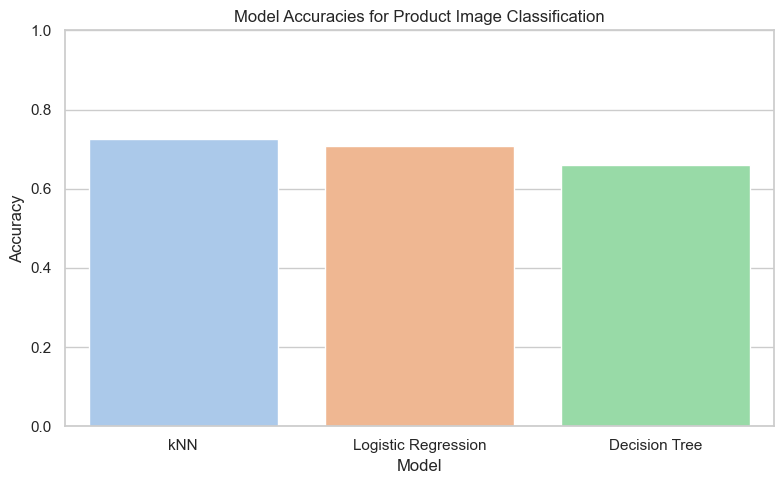

In [682]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Model accuracies
model_accuracies = {
    'kNN': 0.7251781704578737,
    'Logistic Regression': 0.7078980767353314,
    'Decision Tree': 0.66
}

# Convert to DataFrame
df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Seaborn barplot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Model', y='Accuracy', palette='pastel')
plt.ylim(0, 1)
plt.title('Model Accuracies for Product Image Classification')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig('images/initial_model_accuracies.png', dpi=300, bbox_inches='tight')
plt.show()

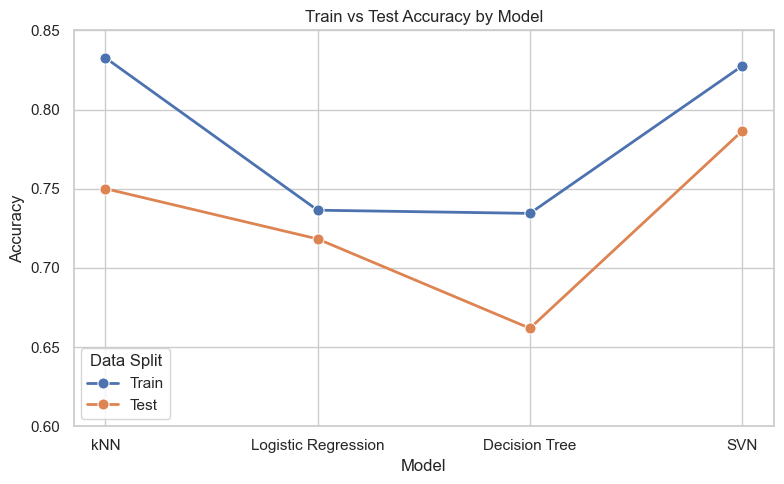

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy data
#SCV Train Accuracy : 0.8275398619341439
#SCV Test Accuracy : 0.7864646958221354
data = {
    'Model': ['kNN', 'kNN', 'Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Decision Tree', 'SVN', 'SVN'],
    'Set': ['Train', 'Test'] * 4,
    'Accuracy': [
        0.8327326043130308, 0.7500610798924994,  # kNN
        0.7364530514997861, 0.718299535792817,   # Logistic Regression
        0.7344370456350419, 0.6618617151233814,   # Decision Tree
        0.8275398619341439, 0.7864646958221354   #SVN with Decomposition
    ]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Line + dot plot
sns.lineplot(data=df, x="Model", y="Accuracy", hue="Set", marker='o', linewidth=2, markersize=8)

plt.ylim(0.6, 0.85)
plt.title("Train vs Test Accuracy by Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Data Split")
plt.tight_layout()
plt.savefig("images/test_train_acc.png")
plt.show()

# PCA with SCM 
Because SVM took too long, I used PCA to reduce the data to 100 components instead of 24,000.
The results for SVM after using PCA were solid and the time to compute was considerably less.  The test accuracy was 78%, resulting in the highest accuracy for a model so far.

In [203]:
#Using PCA to take the image data to 100 components instead of over 24,000
#This greatly helped computation times.

from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

svm = SVC()
svm.fit(X_train_reduced, y_train)

In [576]:
import joblib
joblib.dump(pca, "models/pca_transformer.joblib")
joblib.dump(svm, "models/svm_model.joblib")

['models/pca_transformer.joblib']

In [200]:
svm_train_accuracy = svm.score(X_train_reduced, y_train)
svm_test_accuracy = svm.score(X_test_reduced, y_test)
print ("SVM Train Accuracy : " + str(svm_train_accuracy))
print ("SVM Test Accuracy : " + str(svm_test_accuracy))

SVM Train Accuracy : 0.8273565886737125
SVM Test Accuracy : 0.7857317371121427


In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

top_classes = y_test.value_counts().nlargest(10).index
y_pred = model.predict(X_test)
# Filter y_test and y_pred to only include these
mask = y_test.isin(top_classes)
filtered_y_test = y_test[mask]
filtered_y_pred = pd.Series(y_pred, index=y_test.index)[mask]


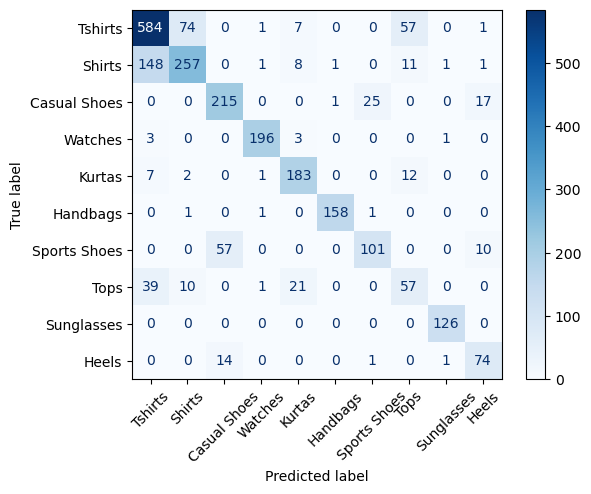

In [219]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [551]:
def get_per_class_accuracy(y_true, y_pred, top_classes):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).T
    df = df.loc[df.index.isin(top_classes)]
    return df['recall'].reindex(top_classes).tolist()  # recall = accuracy per class

In [ ]:
#FIRST TRY CNN 

In [400]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [519]:
#load the images

IMAGE_SIZE = (64, 64)

def preprocess_image_for_cnn(path):
    img = Image.open(path).convert('L').resize(IMAGE_SIZE)  # Grayscale, 
    img_array = np.array(img) / 255.0  # Normalize
    return img_array.reshape((64, 64, 1))  # Keep channel dimension

X = np.array([preprocess_image_for_cnn(p) for p in styles['image_path']])
y = styles['articleType'].astype('category').cat.codes  # Convert labels to integers

# Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


# One-hot encode labels for Keras
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)



# Creating a CNN Model

After a first pass with 5 epochs the results was 83% training accuracy and 77.89% for the test data accuracy.

461/461 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.8366 - loss: 0.5229 - val_accuracy: 0.7789 - val_loss: 0.7676
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7864 - loss: 0.7985


The next step was to try 10 epochs.
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8002 - loss: 0.9510
At this point it started to overfit

Epoch 6 had the lowest loss.

Other things changed : Change the convert to RGB instead of grayscale to see if the color information helps the model.
Also set shuffle=True in train_test_split to ensure that the training and test sets are representative of the overall data distribution. 
Although the accuracy went down slightly when I set shuffle=True, I may be getting more trustworthy data.


While validation loss was lowest at epoch 6, validation accuracy continued to improve, and the final model achieved the best performance on the test set after 10 epochs.

In [421]:
#Create a CNN model

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y_train_cat.shape[1], activation='softmax')  # num_classes
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = cnn_model.fit(X_train, y_train_cat, epochs=10, validation_split=0.1)

cnn_model.save('models/my_cnn_model.h5')  # Saves in HDF5 format

Epoch 1/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.4315 - loss: 2.3396 - val_accuracy: 0.7104 - val_loss: 1.1036
Epoch 2/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.7354 - loss: 0.9691 - val_accuracy: 0.7538 - val_loss: 0.8963
Epoch 3/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.7870 - loss: 0.7395 - val_accuracy: 0.7752 - val_loss: 0.8120
Epoch 4/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.8132 - loss: 0.6131 - val_accuracy: 0.7807 - val_loss: 0.7737
Epoch 5/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.8447 - loss: 0.5157 - val_accuracy: 0.7947 - val_loss: 0.7673
Epoch 6/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.8655 - loss: 0.4366 - val_accuracy: 0.7996 - val_loss: 0.7802
Epoch 7/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.8870 - loss: 0.3693 - val_accuracy: 0.7850 - val_loss: 0.8637
Epoch 8/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.8995 - loss: 0.3120 - 

In [438]:
#Evaluate the CNN model 
train_loss, train_acc = cnn_model.evaluate(X_train, y_train_cat)
print("Train accuracy:", train_acc)
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_cat)
print("Test accuracy:", test_acc)

512/512 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9218 - loss: 0.2190
Train accuracy: 0.9137393832206726
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8065 - loss: 0.8887
Test accuracy: 0.8106523156166077


## Confusion Matrix for My Custom CNN

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Kurtas', 'Sports Shoes', 'Tops', 'Sunglasses', 'Handbags', 'Heels']


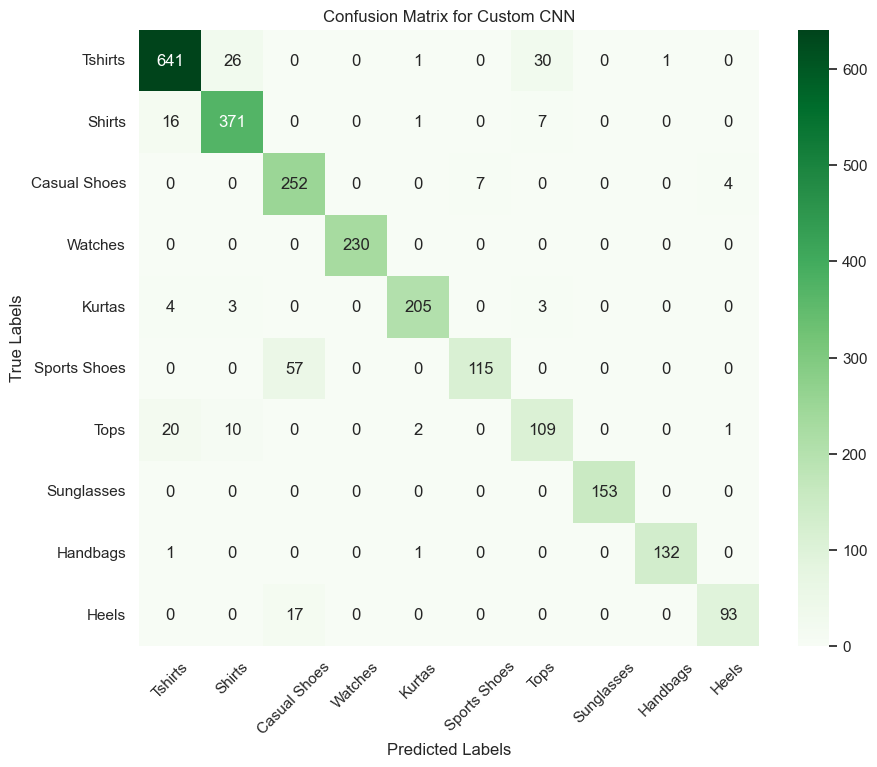

In [688]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Load SVM model
pca = joblib.load("models/pca_transformer.joblib")
svm = joblib.load("models/svm_model.joblib")

# Load custom CNN model
cnn_model = load_model("models/my_cnn_model.h5")
# Get predicted probabilities
y_pred_probs = cnn_model.predict(X_test)

# Convert to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class indices
y_true = np.argmax(Y_test, axis=1)


label_encoder = LabelEncoder()
label_encoder.fit(styles['articleType'])  # Or the full list of raw labels


y_pred_class_indices = np.argmax(y_pred_probs, axis=1)

# Step 2: Decode predictions and true labels into strings
y_pred_labels = label_encoder.inverse_transform(y_pred_class_indices)
y_true_labels = label_encoder.inverse_transform(y_true)  # assuming y_true is encoded

# Step 3: Get top 10 most frequent TRUE classes
top_class_names = pd.Series(y_true_labels).value_counts().head(10).index.tolist()
print (top_class_names)

# Step 4: Filter both y_true and y_pred to only these top classes
mask = np.isin(y_true_labels, top_class_names)
filtered_y_true = y_true_labels[mask]
filtered_y_pred = y_pred_labels[mask]

# Step 5: Confusion matrix using string class names
cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=top_class_names)
cm_df = pd.DataFrame(cm, index=top_class_names, columns=top_class_names)

# Step 3: Build filtered confusion matrix
#cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=top_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Custom CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.savefig("confusion_matrix_cnn.png", bbox_inches='tight')  # ← save the image
plt.show()

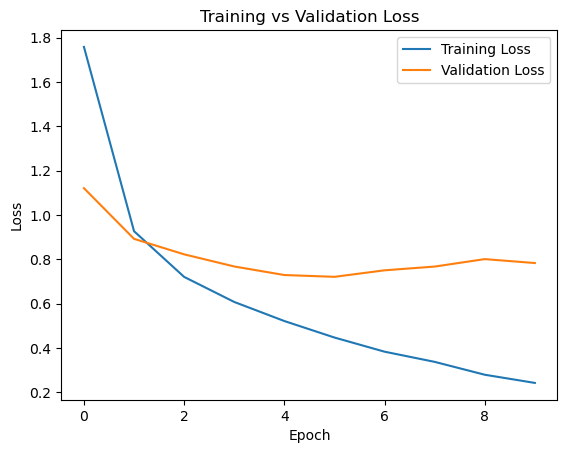

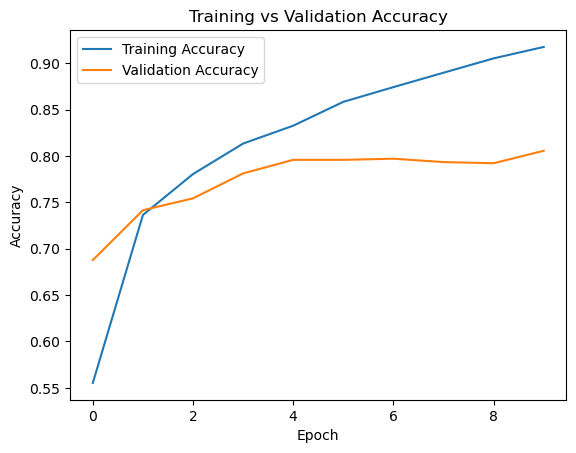

In [51]:
import matplotlib.pyplot as plt


# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Accuracy (optional)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

warnings.filterwarnings('ignore')

In [3]:


###################################################################
#THEN try a pretrained model

In [700]:
from PIL import Image
import numpy as np

IMAGE_SIZE = (128, 128)

def preprocess_image(path):
    img = Image.open(path).convert('RGB').resize(IMAGE_SIZE)
    return np.array(img) / 255.0  # normalize to [0, 1]

X = np.array([preprocess_image(p) for p in styles['image_path']])

In [702]:
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# Replace mnist.load_data with this:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y_cat, test_size=0.2, shuffle=True, random_state=42
)

In [704]:
tf.random.set_seed(42)
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the base model with pretrained ImageNet weights
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
### BEGIN SOLUTION
# Step 1: Load pretrained base model
#base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze it for selective fine-tuning

# Step 2: Freeze all layers except the last 5
for layer in base_model.layers[:-5]: #changed from 5 to 20
    layer.trainable = False

# Step 3: Add custom head
num_classes = styles['articleType'].nunique()
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Step 4: Compile with low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Step 5: Train the model (fine-tuning phase)

early_stop = EarlyStopping(
    monitor='val_loss',        # Watch validation loss
    patience=2,                # Wait 2 epochs before stopping after no improvement
    restore_best_weights=True # Restore weights from the best epoch
)
#model.load_weights("weights/MobileNetV2_100_pretrained_nn.weights.h5") #loaded saved weights from previous fit
#history = model.fit(X_train, Y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

In [706]:
model.load_weights("weights/MobileNetV2_100_pretrained_nn.weights.h5") #loaded saved weights from previous fit
train_loss, train_acc = model.evaluate(X_train, Y_train)
print("Train accuracy for MobileNetV2:", train_acc)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy for MobileNetV2:", test_acc)

512/512 ━━━━━━━━━━━━━━━━━━━━ 235s 435ms/step - accuracy: 0.9343 - loss: 0.2055
Train accuracy for MobileNetV2: 0.9300507307052612
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 434ms/step - accuracy: 0.8767 - loss: 0.4358
Test accuracy for MobileNetV2: 0.8744197487831116


In [470]:
#model.save_weights("MobileNetV2_100_pretrained_nn.weights.h5")
model.save("models/MobileNetV2_full_model.h5")

In [116]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy for ResNet50 Test 1 :", test_acc)

128/128 ━━━━━━━━━━━━━━━━━━━━ 103s 802ms/step - accuracy: 0.7577 - loss: 0.9124
Test accuracy for ResNet50 Test 1 : 0.7569020390510559


# Fine-Tuned MobileNetV2 Pretrained on ImageNet

My first attempt at a pretrained model gave 75.65% accurasy as a result.  I was hoping for better than my CNN model, but it looks like I will have to optimize the model to see if I can make it better.  

## Settings for the first model :  epochs 5, freeze 5 layers, used MobileNetV2 model`

![Alt text](images/mobilenetv2_model.png)


#### First Model 76% Accuracy
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - accuracy: 0.7565 - loss: 0.9678
Test accuracy: 0.7600781917572021


Changes to make : 
1.  The first thing that I should try is increase the epochs.  Maybe just change it to 6 or 7 would improve the model.
2.  Another thing I'd like to try is changing the base model to ResNet50 instead of MobileNetV2
3,  Also I'd like to change the pretrained dataset to the fashion dataset instead of the general image dataset.
4.  Unfreeze 20 layers instead of 5
   
## Settings for the second model :  epochs 5, freeze 20 layers, used RestNet50 moded
Using the ResNet50 model made the results take much longer and the changes resulted in only a very slight increase in accuracy.
Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.2175 - loss: 3.6846 - val_accuracy: 0.4997 - val_loss: 2.2953
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.5481 - loss: 1.9410 - val_accuracy: 0.6591 - val_loss: 1.4271
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.6478 - loss: 1.4856 - val_accuracy: 0.6946 - val_loss: 1.1938
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.6899 - loss: 1.2482 - val_accuracy: 0.7221 - val_loss: 1.0723
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.7221 - loss: 1.0886 - val_accuracy: 0.7318 - val_loss: 0.9944

#### Second Model with ResNet50 75.7% accuracy
mhResult for second model : 
128/128 ━━━━━━━━━━━━━━━━━━━━ 103s 802ms/step - accuracy: 0.7577 - loss: 0.9124
Test accuracy for ResNet50 Test 1 : 0.7569020390510559

## Settings for the third model : epochs 10, freeze 5 layers, used MobileNetV2 model again
Epoch 1/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 259s 544ms/step - accuracy: 0.1287 - loss: 4.1100 - val_accuracy: 0.5199 - val_loss: 2.3404
Epoch 2/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 309s 671ms/step - accuracy: 0.5237 - loss: 2.2941 - val_accuracy: 0.6384 - val_loss: 1.6652
Epoch 3/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 339s 707ms/step - accuracy: 0.6131 - loss: 1.7739 - val_accuracy: 0.6903 - val_loss: 1.3468
Epoch 4/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 302s 656ms/step - accuracy: 0.6540 - loss: 1.5169 - val_accuracy: 0.7172 - val_loss: 1.1586
Epoch 5/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 270s 585ms/step - accuracy: 0.6792 - loss: 1.3435 - val_accuracy: 0.7440 - val_loss: 1.0279
Epoch 6/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 348s 642ms/step - accuracy: 0.7123 - loss: 1.1947 - val_accuracy: 0.7544 - val_loss: 0.9351
Epoch 7/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 341s 683ms/step - accuracy: 0.7202 - loss: 1.1049 - val_accuracy: 0.7697 - val_loss: 0.8636
Epoch 8/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 323s 702ms/step - accuracy: 0.7406 - loss: 1.0301 - val_accuracy: 0.7813 - val_loss: 0.8084
Epoch 9/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 385s 708ms/step - accuracy: 0.7528 - loss: 0.9774 - val_accuracy: 0.7947 - val_loss: 0.7618
Epoch 10/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 290s 628ms/step - accuracy: 0.7588 - loss: 0.9162 - val_accuracy: 0.7996 - val_loss: 0.7263

128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 542ms/step - accuracy: 0.8132 - loss: 0.6940

#### Third Attempt 81% Accuracy
Result for third model: 
With 10 epochs the accuracy went to 81%.  The loss keeps going down so the next thing I'll try is 20 epochs to see if the loss starts to level off.

## Settings for fourth model : epochs 20, freeze 5 layers, used MobileNetV2 model

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 324s 661ms/step - accuracy: 0.1236 - loss: 4.2434 - val_accuracy: 0.4905 - val_loss: 2.4078
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 283s 576ms/step - accuracy: 0.5248 - loss: 2.3483 - val_accuracy: 0.6408 - val_loss: 1.6361
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 259s 561ms/step - accuracy: 0.6160 - loss: 1.7530 - val_accuracy: 0.7049 - val_loss: 1.2814
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 247s 528ms/step - accuracy: 0.6578 - loss: 1.4892 - val_accuracy: 0.7263 - val_loss: 1.0928
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 230s 499ms/step - accuracy: 0.6812 - loss: 1.3269 - val_accuracy: 0.7483 - val_loss: 0.9696
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 234s 508ms/step - accuracy: 0.7050 - loss: 1.2041 - val_accuracy: 0.7599 - val_loss: 0.8907
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 240s 520ms/step - accuracy: 0.7251 - loss: 1.0901 - val_accuracy: 0.7679 - val_loss: 0.8265
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 268s 581ms/step - accuracy: 0.7361 - loss: 1.0250 - val_accuracy: 0.7789 - val_loss: 0.7743
Epoch 9/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 248s 538ms/step - accuracy: 0.7557 - loss: 0.9599 - val_accuracy: 0.7892 - val_loss: 0.7338
Epoch 10/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 424s 920ms/step - accuracy: 0.7633 - loss: 0.9099 - val_accuracy: 0.7954 - val_loss: 0.7066
Epoch 11/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 68s 148ms/step - accuracy: 0.7740 - loss: 0.8576 - val_accuracy: 0.8033 - val_loss: 0.6780
Epoch 12/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 223s 484ms/step - accuracy: 0.7808 - loss: 0.8211 - val_accuracy: 0.8119 - val_loss: 0.6560
Epoch 13/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 232s 503ms/step - accuracy: 0.7830 - loss: 0.7825 - val_accuracy: 0.8198 - val_loss: 0.6368
Epoch 14/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 264s 572ms/step - accuracy: 0.7971 - loss: 0.7446 - val_accuracy: 0.8210 - val_loss: 0.6182
Epoch 15/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 328s 584ms/step - accuracy: 0.7985 - loss: 0.7249 - val_accuracy: 0.8277 - val_loss: 0.6049
Epoch 16/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 322s 585ms/step - accuracy: 0.8076 - loss: 0.6839 - val_accuracy: 0.8283 - val_loss: 0.5936
Epoch 17/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 308s 555ms/step - accuracy: 0.8151 - loss: 0.6666 - val_accuracy: 0.8320 - val_loss: 0.5774
Epoch 18/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 239s 518ms/step - accuracy: 0.8163 - loss: 0.6498 - val_accuracy: 0.8363 - val_loss: 0.5677
Epoch 19/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 223s 484ms/step - accuracy: 0.8183 - loss: 0.6174 - val_accuracy: 0.8412 - val_loss: 0.5580
Epoch 20/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.8242 - loss: 0.6036 - val_accuracy: 0.8412 - val_loss: 0.5538

#### Fourth Attempt 85% Accuracy
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.8538 - loss: 0.5333
Test accuracy for MobileNetV2: 0.8546298742294312

The loss still seems to be decreasing so I will keep adding epochs to see if the accuracy can improve. 
## Settings for fifth model : epochs 50, freeze 5 layers, used MobileNetV2 model

The model stopped at 47 epochs.  The loss stopped improving and I had EarlyStopping set to happen after the model stopped improving.  The loss was the lowest at epoch 45.

Epoch 1/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 339s 684ms/step - accuracy: 0.1361 - loss: 4.2479 - val_accuracy: 0.4856 - val_loss: 2.5004
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 277s 601ms/step - accuracy: 0.4919 - loss: 2.3850 - val_accuracy: 0.6378 - val_loss: 1.7068
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 277s 602ms/step - accuracy: 0.6023 - loss: 1.7864 - val_accuracy: 0.6970 - val_loss: 1.3128
Epoch 4/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 299s 552ms/step - accuracy: 0.6582 - loss: 1.4600 - val_accuracy: 0.7257 - val_loss: 1.0990
Epoch 5/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 279s 605ms/step - accuracy: 0.6906 - loss: 1.2862 - val_accuracy: 0.7520 - val_loss: 0.9662
Epoch 6/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 296s 549ms/step - accuracy: 0.7103 - loss: 1.1709 - val_accuracy: 0.7673 - val_loss: 0.8824
Epoch 7/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 276s 598ms/step - accuracy: 0.7277 - loss: 1.0796 - val_accuracy: 0.7734 - val_loss: 0.8227
Epoch 8/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 302s 553ms/step - accuracy: 0.7397 - loss: 1.0127 - val_accuracy: 0.7868 - val_loss: 0.7752
Epoch 9/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 270s 570ms/step - accuracy: 0.7587 - loss: 0.9428 - val_accuracy: 0.7929 - val_loss: 0.7378
Epoch 10/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 336s 599ms/step - accuracy: 0.7666 - loss: 0.8864 - val_accuracy: 0.8002 - val_loss: 0.7078
Epoch 11/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 255s 553ms/step - accuracy: 0.7739 - loss: 0.8461 - val_accuracy: 0.8051 - val_loss: 0.6852
Epoch 12/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 10974s 24s/step - accuracy: 0.7836 - loss: 0.8157 - val_accuracy: 0.8100 - val_loss: 0.6600
Epoch 13/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 76s 166ms/step - accuracy: 0.7847 - loss: 0.7789 - val_accuracy: 0.8137 - val_loss: 0.6392
Epoch 14/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 243s 528ms/step - accuracy: 0.7946 - loss: 0.7399 - val_accuracy: 0.8204 - val_loss: 0.6211
Epoch 15/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 252s 546ms/step - accuracy: 0.8023 - loss: 0.7104 - val_accuracy: 0.8222 - val_loss: 0.6090
Epoch 16/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 247s 536ms/step - accuracy: 0.8124 - loss: 0.6915 - val_accuracy: 0.8314 - val_loss: 0.5949
Epoch 17/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 252s 546ms/step - accuracy: 0.8152 - loss: 0.6665 - val_accuracy: 0.8314 - val_loss: 0.5830
Epoch 18/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 264s 574ms/step - accuracy: 0.8197 - loss: 0.6428 - val_accuracy: 0.8332 - val_loss: 0.5707
Epoch 19/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 341s 614ms/step - accuracy: 0.8227 - loss: 0.6081 - val_accuracy: 0.8345 - val_loss: 0.5594
Epoch 20/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 286s 621ms/step - accuracy: 0.8300 - loss: 0.5939 - val_accuracy: 0.8375 - val_loss: 0.5525
Epoch 21/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1858s 4s/step - accuracy: 0.8314 - loss: 0.5861 - val_accuracy: 0.8387 - val_loss: 0.5455
Epoch 22/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 187s 406ms/step - accuracy: 0.8363 - loss: 0.5779 - val_accuracy: 0.8412 - val_loss: 0.5351
Epoch 23/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 284s 616ms/step - accuracy: 0.8387 - loss: 0.5497 - val_accuracy: 0.8454 - val_loss: 0.5278
Epoch 24/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 223s 400ms/step - accuracy: 0.8410 - loss: 0.5440 - val_accuracy: 0.8467 - val_loss: 0.5230
Epoch 25/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 243s 527ms/step - accuracy: 0.8416 - loss: 0.5372 - val_accuracy: 0.8509 - val_loss: 0.5166
Epoch 26/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 256s 555ms/step - accuracy: 0.8527 - loss: 0.5089 - val_accuracy: 0.8516 - val_loss: 0.5114
Epoch 27/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 253s 536ms/step - accuracy: 0.8544 - loss: 0.4826 - val_accuracy: 0.8540 - val_loss: 0.5070
Epoch 28/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 252s 547ms/step - accuracy: 0.8602 - loss: 0.4751 - val_accuracy: 0.8558 - val_loss: 0.5023
Epoch 29/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 281s 587ms/step - accuracy: 0.8573 - loss: 0.4768 - val_accuracy: 0.8558 - val_loss: 0.4993
Epoch 30/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 303s 546ms/step - accuracy: 0.8618 - loss: 0.4618 - val_accuracy: 0.8571 - val_loss: 0.4973
Epoch 31/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 253s 549ms/step - accuracy: 0.8640 - loss: 0.4548 - val_accuracy: 0.8564 - val_loss: 0.4913
Epoch 32/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 259s 561ms/step - accuracy: 0.8648 - loss: 0.4491 - val_accuracy: 0.8564 - val_loss: 0.4849
Epoch 33/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 200s 433ms/step - accuracy: 0.8725 - loss: 0.4320 - val_accuracy: 0.8558 - val_loss: 0.4824
Epoch 34/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 262s 569ms/step - accuracy: 0.8739 - loss: 0.4197 - val_accuracy: 0.8583 - val_loss: 0.4795
Epoch 35/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 269s 582ms/step - accuracy: 0.8746 - loss: 0.4058 - val_accuracy: 0.8601 - val_loss: 0.4800
Epoch 36/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.8787 - loss: 0.4000 - val_accuracy: 0.8589 - val_loss: 0.4751
Epoch 37/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 121s 263ms/step - accuracy: 0.8834 - loss: 0.3824 - val_accuracy: 0.8626 - val_loss: 0.4708
Epoch 38/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 276s 553ms/step - accuracy: 0.8832 - loss: 0.3886 - val_accuracy: 0.8613 - val_loss: 0.4689
Epoch 39/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 255s 552ms/step - accuracy: 0.8879 - loss: 0.3674 - val_accuracy: 0.8607 - val_loss: 0.4682
Epoch 40/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 277s 584ms/step - accuracy: 0.8932 - loss: 0.3597 - val_accuracy: 0.8601 - val_loss: 0.4660
Epoch 41/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 236s 512ms/step - accuracy: 0.8943 - loss: 0.3495 - val_accuracy: 0.8626 - val_loss: 0.4630
Epoch 42/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 300s 595ms/step - accuracy: 0.8938 - loss: 0.3431 - val_accuracy: 0.8613 - val_loss: 0.4629
Epoch 43/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 234s 508ms/step - accuracy: 0.8957 - loss: 0.3340 - val_accuracy: 0.8632 - val_loss: 0.4627
Epoch 44/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 307s 605ms/step - accuracy: 0.8998 - loss: 0.3327 - val_accuracy: 0.8632 - val_loss: 0.4602
Epoch 45/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 305s 568ms/step - accuracy: 0.9014 - loss: 0.3226 - val_accuracy: 0.8644 - val_loss: 0.4555
Epoch 46/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 273s 592ms/step - accuracy: 0.9028 - loss: 0.3177 - val_accuracy: 0.8644 - val_loss: 0.4570
Epoch 47/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 261s 566ms/step - accuracy: 0.9063 - loss: 0.3098 - val_accuracy: 0.8668 - val_loss: 0.4556

============================================================================================================================
============================================================================================================================
#### Final Attempt! 87% accuracy
128/128 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.8767 - loss: 0.4358
Test accuracy for MobileNetV2: 0.8744197487831116

In [708]:
# Get predicted class indices
#Load the model that was saved out
#model = load_model('my_model.h5')
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices (if one-hot encoded)
y_true = np.argmax(Y_test, axis=1)

128/128 ━━━━━━━━━━━━━━━━━━━━ 58s 430ms/step


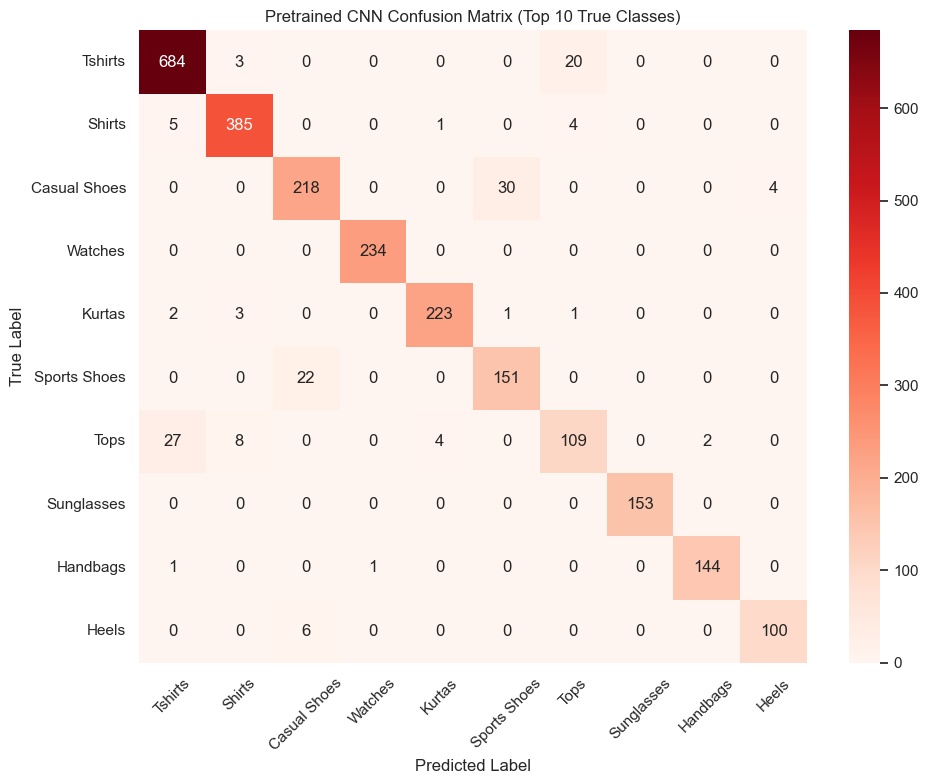

In [714]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Step 1: Load model and predict
label_encoder = LabelEncoder()
label_encoder.fit(styles['articleType'])  # Or the full list of raw labels


y_pred_class_indices = np.argmax(y_pred_probs, axis=1)

# Step 2: Decode predictions and true labels into strings
y_pred_labels = label_encoder.inverse_transform(y_pred_class_indices)
y_true_labels = label_encoder.inverse_transform(y_true)  # assuming y_true is encoded

# Step 3: Get top 10 most frequent TRUE classes
top_class_names = pd.Series(y_true_labels).value_counts().head(10).index.tolist()

# Step 4: Filter both y_true and y_pred to only these top classes
mask = np.isin(y_true_labels, top_class_names)
filtered_y_true = y_true_labels[mask]
filtered_y_pred = y_pred_labels[mask]

# Step 5: Confusion matrix using string class names
cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=top_class_names)

# Step 6: Plot
cm_df = pd.DataFrame(cm, index=top_class_names, columns=top_class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title('Pretrained CNN Confusion Matrix (Top 10 True Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/pretrained_cnn_heatmap.png")
plt.show()

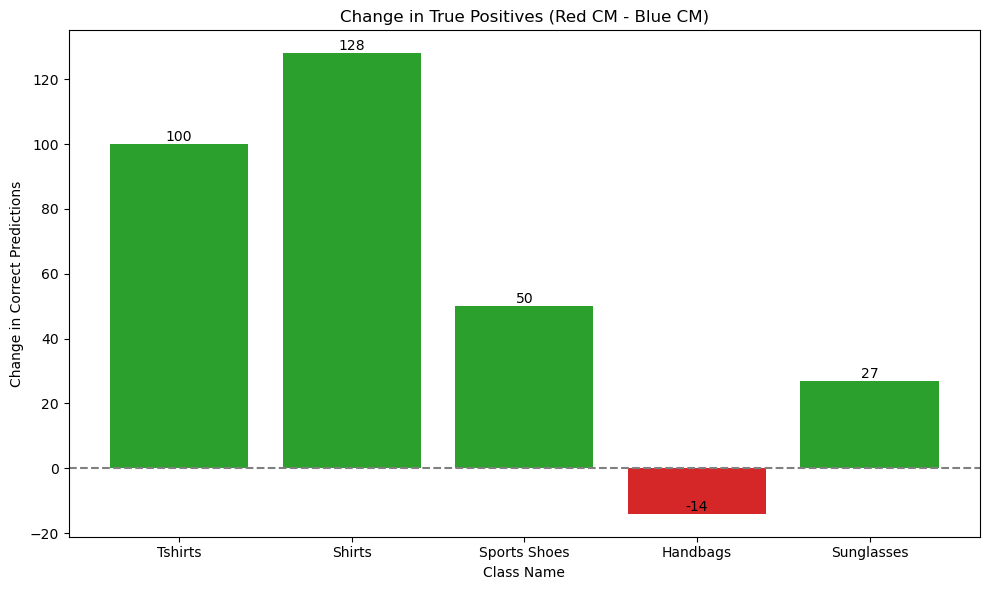

In [359]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Define confusion matrix true positive values
# Format: [Blue CM, Red CM]
data = {
    'Tshirts': [584, 684],
    'Shirts': [257, 385],
    'Sports Shoes': [101, 151],
    'Handbags': [158, 144],
    'Sunglasses': [126, 153]
}

# Step 2: Create DataFrame
df = pd.DataFrame(data, index=['Blue CM', 'Red CM']).T

# Step 3: Compute the improvement (Red - Blue)
df["Improvement"] = df["Red CM"] - df["Blue CM"]

# Step 4: Plot the improvement
plt.figure(figsize=(10, 6))
bars = plt.bar(df.index, df["Improvement"], color=np.where(df["Improvement"] > 0, '#2ca02c', '#d62728'))

# Step 5: Add text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)}', ha='center', va='bottom')

# Step 6: Styling
plt.title('Change in True Positives (Red CM - Blue CM)')
plt.ylabel('Change in Correct Predictions')
plt.xlabel('Class Name')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

## There are fewer handbags classified correctly.  What happened to the missing handbags?  
### I'm only showing the top ten categories in the red confusion matrix.
### The other 8 were misclassified, spread across a few unrelated categories (see below for info on misclassification)




In [370]:

# See how many true handbag items exist
handbag_true_count = sum(y_true_labels == "Handbags")

# See where those items were predicted as (correct or incorrect)
handbag_mask = (y_true_labels == "Handbags")
handbag_predictions = pd.Series(y_pred_labels[handbag_mask]).value_counts()

print("Total Handbag Items:", handbag_true_count)
print("Predicted As:\n", handbag_predictions)

Total Handbag Items: 152
Predicted As:
 Handbags      144
Wallets         3
Briefs          1
Tshirts         1
Belts           1
Laptop Bag      1
Watches         1
Name: count, dtype: int64


# The  Fine-Tuned MobileNetV2 Pretrained on ImageNet Wins
The   Fine-Tuned MobileNetV2 Pretrained on ImageNet wins in every case — better precision, better recall, fewer confusing errors.
The improvement is especially dramatic for Tshirts/Shirts.
The only category that 

# Ensemble Method 
The  Fine-Tuned MobileNetV2 Pretrained on ImageNet Wins, SVM and my CNN model were the other top performers.
The ensemble method will attept to use the best aspects of each model.  The Fine-Tuned was by far the winner though so we'll see how much to use the other models.  I would use the SVM model on handbags, but the Fine-Tuned MobileNetV2 on the other categories.

from tensorflow.keras.models import load_model

red_model = load_model("my_red_model.h5") # Pretrained Neural Network
blue_model = load_model("my_blue_model.h5") #

# Final Results 

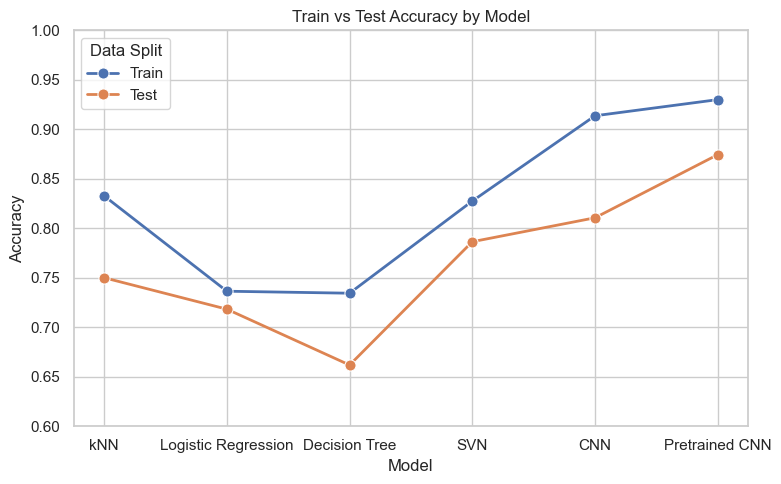

In [621]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy data
#SCV Train Accuracy : 0.8275398619341439
#SCV Test Accuracy : 0.7864646958221354
data = {
    'Model': ['kNN', 'kNN', 'Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Decision Tree', 'SVN', 'SVN', 'CNN', 'CNN', 'Pretrained CNN', 'Pretrained CNN'],
    'Set': ['Train', 'Test'] * 6,
    'Accuracy': [
        0.8327326043130308, 0.7500610798924994,  # kNN
        0.7364530514997861, 0.718299535792817,   # Logistic Regression
        0.7344370456350419, 0.6618617151233814,   # Decision Tree
        0.8275398619341439, 0.7864646958221354,   #SVN with Decomposition
        0.9137393832206726, 0.8106523156166077,   # My Custom CNN
        0.9300507307052612, 0.8744197487831116   # Pretrained CNN
    ]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Line + dot plot
sns.lineplot(data=df, x="Model", y="Accuracy", hue="Set", marker='o', linewidth=2, markersize=8)

plt.ylim(0.6, 1.0)
plt.title("Train vs Test Accuracy by Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Data Split")
plt.tight_layout()
plt.savefig("images/test_train_acc.png")
plt.show()

#### The results : SVM, My Custom CNN & the Pretrained and Finally the 🎉Fine-Tuned MobileNetV2 model🎉 as the Winner 

I was first encouranged to see the success of using PCA and SVM to get an accurate result within a reasonable amount of time. 

Then, I was encouraged when I created my own custom cnn and saw the results improve significantly.  
This one started to break down after about the fifth epoch and the loss started going back up.

🎉In contrast the pretrained MobileNetV2 fine-tuned model continued to improve up to the 45th epoch and got all the way up to 87%.  
This was the clear winner and the model improved for almost every category in accuracy, 

#### Takeaways

A few of the things I have learned on this project are:
* To write out the models or weights so that I don't have to re-run them when creating confusion matrices and comparing models.<br>
  My pretrained model took hours to run so luckily I had save the weights and later learned to save the models to save my work.<br>
* Use PCA with SVM.  We had learned this before but I saw a real world example of why this is useful.  SVM would not have been useful without PCA, but I was still able to get a good result.
* Pretrained models are really powerful, but unwieldy and take a long time to process, making evaluating a lot more complicated. <br>
  Writing out the data to files helps.

In [568]:


IMAGE_SIZE = (64, 64)


def preprocess_image_svm(path):
    img = Image.open(path).convert('L').resize(IMAGE_SIZE)
    return np.array(img).flatten()  # Shape: (4096,)

# Assuming styles_test['image_path'] holds the test image paths
X_test_svm = np.array([preprocess_image_svm(p) for p in styles['image_path']])
    
def preprocess_image_for_cnn(path):
    img = Image.open(path).convert('L').resize(IMAGE_SIZE)  # Grayscale, 
    img_array = np.array(img) / 255.0  # Normalize
    return img_array.reshape((64, 64, 1))  # Keep channel dimension

X_test_cnn = np.array([preprocess_image_for_cnn(p) for p in styles['image_path']])

IMAGE_SIZE = (128, 128)

def preprocess_image_for_pretrained_cnn(path):
    img = Image.open(path).convert('RGB').resize(IMAGE_SIZE)
    return np.array(img) / 255.0  # normalize to [0, 1]

X_test_pretrained_cnn = np.array([preprocess_image_for_pretrained_cnn(p) for p in styles['image_path']])





# Find Category Accuracy Values

The section breaks down the accuracy values for each classification so that the different models can be compared based on their classification accuracy.


In [591]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

# Load SVM model
pca = joblib.load("models/pca_transformer.joblib")
svm = joblib.load("models/svm_model.joblib")

# Load custom CNN model
my_custom_cnn = load_model("models/my_cnn_model.h5")

# Load pretrained CNN (MobileNetV2 full model)
pretrained_cnn = load_model("models/MobileNetV2_full_model.h5")


# Step 1: Encode true labels
y_true = label_encoder.transform(styles['articleType'])

#Step 2: Load the models

# Step 2: Predict with all 3 models
# Apply PCA to test images
X_test_svm_pca = pca.transform(X_test_svm)

# Now you can predict with the SVM
y_pred_svm = svm.predict(X_test_svm_pca)
y_pred_cnn = np.argmax(my_custom_cnn.predict(X_test_cnn), axis=1)
y_pred_pretrained = np.argmax(pretrained_cnn.predict(X_test_pretrained_cnn), axis=1)



640/640 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step
640/640 ━━━━━━━━━━━━━━━━━━━━ 283s 437ms/step


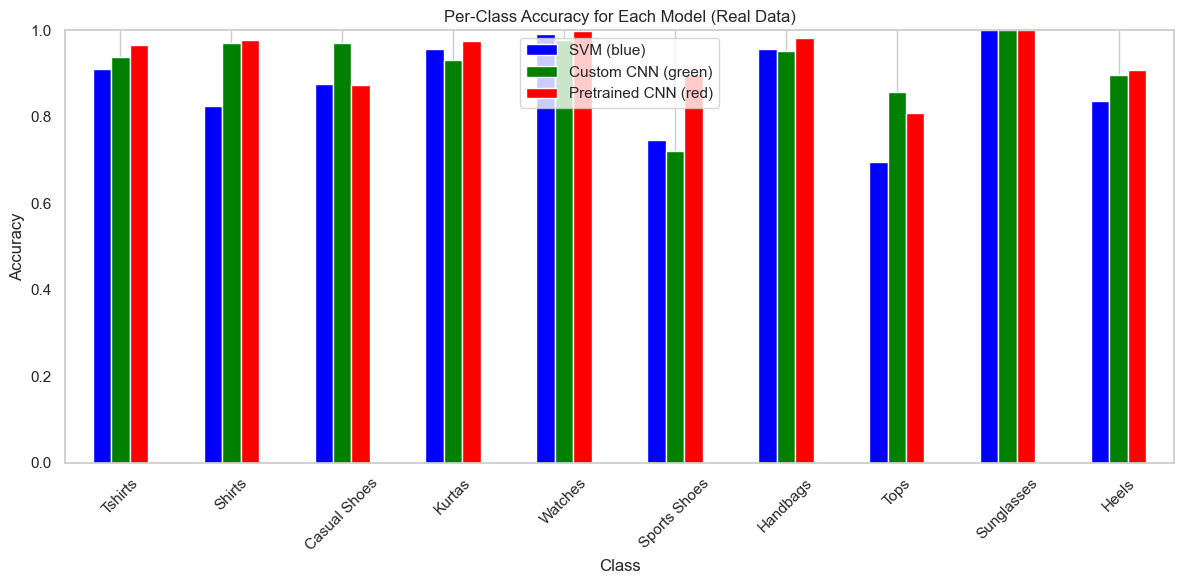

In [626]:
# Step 3: Decode predictions to original labels
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels_svm = y_pred_svm
y_pred_labels_cnn = label_encoder.inverse_transform(y_pred_cnn)
y_pred_labels_pretrained = label_encoder.inverse_transform(y_pred_pretrained)



# Step 4: Get top 10 true classes
top_classes = pd.Series(y_true_labels).value_counts().head(10).index.tolist()

# Step 5: Accuracy function
def get_per_class_accuracy(y_true, y_pred, top_classes):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).T
    df = df.loc[df.index.isin(top_classes)]
    return df['recall'].reindex(top_classes).tolist()

# Step 6: Get accuracy per class
acc_svm = get_per_class_accuracy(y_true_labels, y_pred_labels_svm, top_classes)
acc_cnn = get_per_class_accuracy(y_true_labels, y_pred_labels_cnn, top_classes)
acc_pretrained = get_per_class_accuracy(y_true_labels, y_pred_labels_pretrained, top_classes)



# Step 7: Make DataFrame
acc_df = pd.DataFrame({
    'Class': top_classes,
    'SVM (blue)': acc_svm,
    'Custom CNN (green)': acc_cnn,
    'Pretrained CNN (red)': acc_pretrained
})

# Step 8: Plot
acc_df.set_index('Class').plot(kind='bar', figsize=(12, 6), color=['blue', 'green', 'red'])
plt.title('Per-Class Accuracy for Each Model (Real Data)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("images/model_accuracies_per_category.png", bbox_inches='tight')  # ← save the image
plt.show()

# Ensemble Method 

The custom CNN outperformed the Pretrained CNN in 2 major categories : Casual Shoes and Tops.
The Emsemble method was used to combine the two methods


In [589]:

# Define categories to use Custom CNN for
use_custom_cnn_for = {"Casual Shoes", "Tops"}

# Create the final ensemble prediction list
ensemble_preds = []

# Loop through all predictions
for i in range(len(y_true_labels)):
    true_class = y_true_labels[i]
    
    if true_class in use_custom_cnn_for:
        # Use custom CNN prediction
        ensemble_preds.append(y_pred_labels_cnn[i])
    else:
        # Use pretrained CNN prediction
        ensemble_preds.append(y_pred_labels_pretrained[i])

# Optionally, calculate ensemble accuracy
from sklearn.metrics import accuracy_score
ensemble_accuracy = accuracy_score(y_true_labels, ensemble_preds)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

Ensemble Accuracy: 0.9272


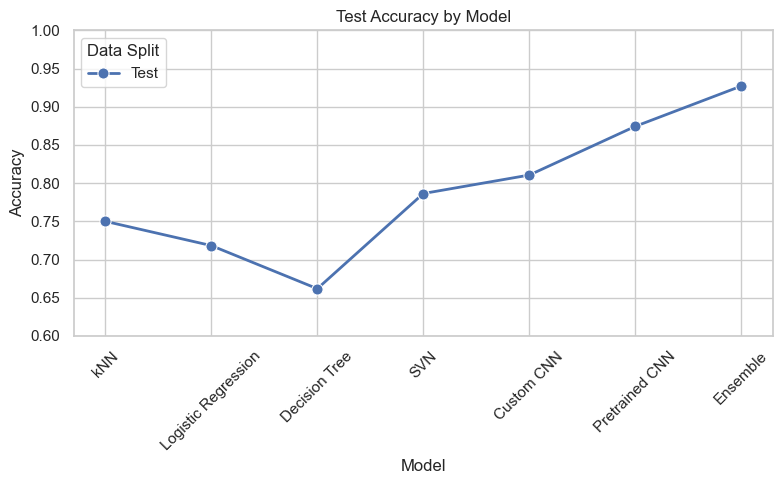

In [616]:
# Accuracy data

data = {
    'Model': ['kNN', 'Logistic Regression', 'Decision Tree', 'SVN',  'Custom CNN', 'Pretrained CNN', 'Ensemble'],
    'Set': ['Test'] * 7,
    'Accuracy': [
        0.7500610798924994,  # kNN
        0.718299535792817,   # Logistic Regression
        0.6618617151233814,   # Decision Tree
        0.7864646958221354,   #SVN with Decomposition
        0.8106523156166077,   # My Custom CNN
        0.8744197487831116,   # Pretrained CNN
        0.9272                # Ensemble Accuracy
    ]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Line + dot plot
sns.lineplot(data=df, x="Model", y="Accuracy", hue="Set", marker='o', linewidth=2, markersize=8)

plt.ylim(0.6, 1.0)
plt.title("Test Accuracy by Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend(title="Data Split")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/final_test_accuracy.png")
plt.show()

## Ensemble Techniques Improved the model even more to 92.7%
By combining the strengths of the Custom CNN model and the Pretrained model, the ensemble approach significantly improved the test accuracy.<br>
This hybrid method leveraged the strengths of each model on specific categories, resulting in more accurate predictions overall. <br>
The ensemble technique proved to be an effective strategy for boosting model performance.
